In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
import re
import collections
import string # library used to deal with text data
import warnings
warnings.filterwarnings("ignore")

In [3]:
import seaborn as sns # data visualization library
import matplotlib.pyplot as plt # plotting library
import plotly.graph_objs as go # interactive plotting library
import plotly.express as px # interactive plotting library
from itertools import cycle # used for cycling colors at plotly graphs
# import pandas_profiling # library for automatic EDA


In [4]:
from scipy import stats # statistical library
from statsmodels.stats.weightstats import ztest # statistical function for hypothesis testing


from IPython.display import display # display from IPython.display

In [5]:
# Importing the data and displaying some rows
df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
# df2 = pd.read_csv("/kaggle/input/playground-series-s5e2/training_extra.csv")
# df = pd.concat([df1, df2], ignore_index=True)
display(df.head(10))

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
5,5,Nike,Canvas,Medium,10.0,No,Yes,NaN,Black,7.241812,20.01553
6,6,Nike,NaN,Large,3.0,No,No,Backpack,Green,6.828123,84.80500
7,7,Puma,Canvas,Small,1.0,Yes,Yes,Backpack,Blue,21.488864,27.15815
8,8,Under Armour,Polyester,Medium,8.0,Yes,No,Tote,Gray,10.207780,25.98652
9,9,Under Armour,Nylon,Medium,2.0,Yes,Yes,Messenger,Pink,15.895100,38.48741


In [6]:
# # The pandas profiling library is really useful on helping us understand the data we're working on.
# # It saves us some precious time on the EDA process.
# report = pandas_profiling.ProfileReport(df)

# # Let's now visualize the report generated by pandas_profiling.
# display(report)

# # Also, there is an option to generate an .HTML file containing all the information generated by the report.
# # report.to_file(output_file='report.html')

In [7]:
df.info(), df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


(None,
 id                         0
 Brand                   9705
 Material                8347
 Size                    6595
 Compartments               0
 Laptop Compartment      7444
 Waterproof              7050
 Style                   7970
 Color                   9950
 Weight Capacity (kg)     138
 Price                      0
 dtype: int64)

In [8]:
# from sklearn.impute import SimpleImputer

# # Handling categorical missing values using mode (most frequent value)
# categorical_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
# cat_imputer = SimpleImputer(strategy="most_frequent")
# df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

# # Handling numerical missing values using median
# num_imputer = SimpleImputer(strategy="median")
# df["Weight Capacity (kg)"] = num_imputer.fit_transform(df[["Weight Capacity (kg)"]])

# # Confirm if missing values are handled
# df.isnull().sum()


In [9]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


# Define Features and Target
target = df["Price"]
df.drop(columns=["Price"], inplace=True)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 22.9+ MB


In [11]:
# Identify Numeric and Categorical Columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=[object]).columns.tolist()
print(numeric_columns)
print(categorical_columns)

['id', 'Compartments', 'Weight Capacity (kg)']
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']


In [12]:
# Split Data (Before Applying Transformations)
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)


In [13]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Define imputation techniques
imputers = {
    'mean_imputer': SimpleImputer(strategy='mean'),
    'median_imputer': SimpleImputer(strategy='median'),
    'knn_imputer': KNNImputer(n_neighbors=5),
    'iterative_imputer': IterativeImputer(random_state=42)
}


In [14]:
# Function to apply imputation
def apply_imputation(X_train, X_test, numeric_columns, categorical_columns, imputer):
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

    # Impute numeric columns
    if numeric_columns:
        X_train_imputed[numeric_columns] = imputer.fit_transform(X_train[numeric_columns])
        X_test_imputed[numeric_columns] = imputer.transform(X_test[numeric_columns])

    # Impute categorical columns with a placeholder
    if categorical_columns:
        X_train_imputed[categorical_columns] = X_train[categorical_columns].fillna('Missing')
        X_test_imputed[categorical_columns] = X_test[categorical_columns].fillna('Missing')

    return X_train_imputed, X_test_imputed

In [15]:
# Define numeric and categorical transformers
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
data_transformations = ColumnTransformer([
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

In [16]:
# Define the pipeline
pipe = Pipeline([
    ('data_transformations', data_transformations),
    ('reg', RandomForestRegressor())  # Placeholder model
])

# Define parameter grid for RandomizedSearchCV
params_grid = [
    {'reg': [RandomForestRegressor()],
     'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
     'reg__max_features': [None, "sqrt", "log2"],
     'reg__max_depth': [int(x) for x in np.linspace(5, 20, num=5)],
     'reg__random_state': [42]},

    {'reg': [LGBMRegressor()],
     'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
     'reg__max_depth': [int(x) for x in np.linspace(3, 15, num=5)],
     'reg__learning_rate': np.linspace(0.01, 0.3, num=5)},

    {'reg': [XGBRegressor()],
     'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
     'reg__max_depth': [int(x) for x in np.linspace(3, 15, num=5)],
     'reg__learning_rate': np.linspace(0.01, 0.3, num=5),
     'reg__gamma': np.linspace(0, 1, num=5),
     'reg__lambda': np.linspace(0.1, 1, num=5)}
]

# Cross Validator
cross_validator = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=7)

# RandomizedSearchCV
best_model_pipeline = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params_grid,
    n_iter=50,
    scoring='r2',
    refit=True,
    n_jobs=-1,
    cv=5,
    random_state=21,
    error_score='raise',
    return_train_score=False
)

In [17]:
# Compare imputation techniques
results = {}
for imputer_name, imputer in imputers.items():
    print(f"Applying {imputer_name}...")
    
    # Apply imputation
    X_train_imputed, X_test_imputed = apply_imputation(X_train, X_test, numeric_columns, categorical_columns, imputer)
    
    # Train the model
    best_model_pipeline.fit(X_train_imputed, y_train)
    
    # Evaluate the model
    y_pred = best_model_pipeline.best_estimator_.predict(X_test_imputed)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Store the results
    results[imputer_name] = {'R²': r2, 'MAE': mae, 'RMSE': rmse}


Applying mean_imputer...
Applying median_imputer...
Applying knn_imputer...
Applying iterative_imputer...


In [18]:
# Print the results
for imputer_name, result in results.items():
    print(f"\n{imputer_name}:")
    print(f"R² = {result['R²']}")
    print(f"MAE = {result['MAE']}")
    print(f"RMSE = {result['RMSE']}")


mean_imputer:
R² = 0.001729083173759527
MAE = 33.6356293545377
RMSE = 38.91007061092747

median_imputer:
R² = 0.0016815576208638605
MAE = 33.63794937007328
RMSE = 38.910996812712455

knn_imputer:
R² = 0.0017572702064976298
MAE = 33.637154866171166
RMSE = 38.909521277496154

iterative_imputer:
R² = 0.001674544269207101
MAE = 33.638533842142316
RMSE = 38.911133490556466


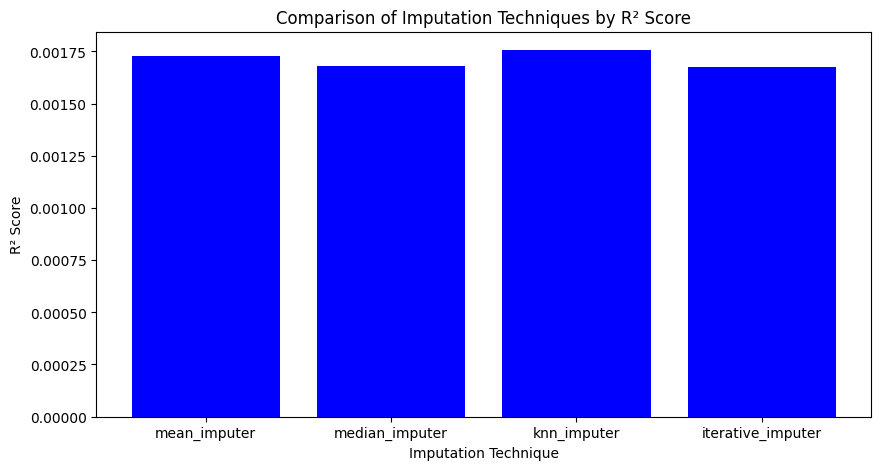


The best imputation technique is: knn_imputer


In [19]:
# Visualize the results
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), [result['R²'] for result in results.values()], color='blue')
plt.xlabel('Imputation Technique')
plt.ylabel('R² Score')
plt.title('Comparison of Imputation Techniques by R² Score')
plt.show()

# Choose the best imputation technique based on the results
best_imputer = max(results, key=lambda x: results[x]['R²'])
print(f"\nThe best imputation technique is: {best_imputer}")

In [20]:
X_train_final, X_test_final = apply_imputation(X_train, X_test, numeric_columns, categorical_columns, imputers[best_imputer])
best_model_pipeline.fit(X_train_final, y_train)

# Evaluate the final model
y_pred_final = best_model_pipeline.best_estimator_.predict(X_test_final)

final_r2 = r2_score(y_test, y_pred_final)
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\n\n#---------------- Best Regression Model Found ----------------#\n\n", best_model_pipeline.best_estimator_[1])
print("\n\n#---------------- Best Estimator's R² Score ----------------#\n\n", final_r2)
print("\n\n#---------------- Mean Absolute Error (MAE) ----------------#\n\n", final_mae)
print("\n\n#---------------- Root Mean Squared Error (RMSE) ----------------#\n\n", final_rmse)



#---------------- Best Regression Model Found ----------------#

 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.75, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0.55,
             learning_rate=0.08249999999999999, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=70, n_jobs=None,
             num_parallel_tree=None, ...)


#---------------- Best Estimator's R² Score ----------------#

 0.0017572702064976298


#---------------- Mean Absolute Error (MAE) ----------------#

 33.63715486617

In [13]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# def fill_na_with_decision_trees(df, numeric_cols, categorical_cols):
#     df_copy = df.copy()
    
#     # Dictionary to store LabelEncoders for categorical columns
#     label_encoders = {}

#     # Encode categorical columns first
#     for col in categorical_cols:
#         le = LabelEncoder()
#         df_copy[col] = df_copy[col].astype(str)  # Convert to string (avoid NaN issues)
#         df_copy[col] = le.fit_transform(df_copy[col])  # Convert to numbers
#         label_encoders[col] = le  # Store encoder for inverse transformation

#     # Fill missing values in numerical columns using DecisionTreeRegressor
#     for col in numeric_cols:
#         if df_copy[col].isnull().sum() > 0:
#             dt_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
#             known_data = df_copy[df_copy[col].notna()]
#             unknown_data = df_copy[df_copy[col].isna()]

#             feature_cols = [c for c in known_data.columns if c != col]

#             if known_data.shape[0] > 1 and not known_data[feature_cols].empty:
#                 dt_reg.fit(known_data[feature_cols], known_data[col])
#                 df_copy.loc[df_copy[col].isna(), col] = dt_reg.predict(unknown_data[feature_cols])

#     # Fill missing values in categorical columns using DecisionTreeClassifier
#     for col in categorical_cols:
#         if df_copy[col].isnull().sum() > 0:
#             dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
#             known_data = df_copy[df_copy[col].notna()]
#             unknown_data = df_copy[df_copy[col].isna()]

#             feature_cols = [c for c in known_data.columns if c != col]

#             if known_data.shape[0] > 1 and not known_data[feature_cols].empty:
#                 dt_clf.fit(known_data[feature_cols], known_data[col])
#                 df_copy.loc[df_copy[col].isna(), col] = dt_clf.predict(unknown_data[feature_cols])

#     # Convert categorical columns back to original labels
#     for col in categorical_cols:
#         df_copy[col] = label_encoders[col].inverse_transform(df_copy[col].astype(int))

#     return df_copy

# # Apply the function to train & test data
# x_train = fill_na_with_decision_trees(x_train, numeric_columns, categorical_columns)
# x_test = fill_na_with_decision_trees(x_test, numeric_columns, categorical_columns)


In [ ]:
# # 1st -> Numeric Transformers
# numeric_transformer = Pipeline([
#     ('scaler', MinMaxScaler())
# ])

# # 2nd -> Categorical Transformers
# categorical_transformer = Pipeline([
#     ('leaveoneout', LeaveOneOutEncoder(sigma=0.1))
# ])

# # 3rd -> Combining Numeric & Categorical Pipelines
# data_transformations = ColumnTransformer([
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # 4th -> Pipeline & RandomizedSearchCV
# pipe = Pipeline([
#     ('data_transformations', data_transformations),
#     ('reg', RandomForestRegressor())  # Placeholder model
# ])

# params_grid = [
#     {'reg': [RandomForestRegressor()],
#      'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
#      'reg__max_features': [None, "sqrt", "log2"],
#      'reg__max_depth': [int(x) for x in np.linspace(5, 20, num=5)],
#      'reg__random_state': [42]},

#     {'reg': [LGBMRegressor()],
#      'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
#      'reg__max_depth': [int(x) for x in np.linspace(3, 15, num=5)],
#      'reg__learning_rate': np.linspace(0.01, 0.3, num=5)},

#     {'reg': [XGBRegressor()],
#      'reg__n_estimators': [int(x) for x in np.linspace(10, 100, num=10)],
#      'reg__max_depth': [int(x) for x in np.linspace(3, 15, num=5)],
#      'reg__learning_rate': np.linspace(0.01, 0.3, num=5),
#      'reg__gamma': np.linspace(0, 1, num=5),
#      'reg__lambda': np.linspace(0.1, 1, num=5)}
# ]

# # Cross Validator
# cross_validator = StratifiedShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=7)

# # RandomizedSearchCV
# best_model_pipeline = RandomizedSearchCV(
#     estimator=pipe,
#     param_distributions=params_grid,
#     n_iter=50,
#     scoring='r2',
#     refit=True,
#     n_jobs=-1,
#     cv=5,
#     random_state=21,
#     error_score='raise',
#     return_train_score=False
# )

# # Train Best Model
# best_model_pipeline.fit(x_train, y_train)

# # Evaluate Best Model
# y_pred = best_model_pipeline.best_estimator_.predict(x_test)

# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print("\n\n#---------------- Best Regression Model Found ----------------#\n\n", best_model_pipeline.best_estimator_[1])
# print("\n\n#---------------- Best Estimator's R² Score ----------------#\n\n", r2)
# print("\n\n#---------------- Mean Absolute Error (MAE) ----------------#\n\n", mae)
# print("\n\n#---------------- Root Mean Squared Error (RMSE) ----------------#\n\n", rmse)


In [21]:
# Function to apply imputation
def apply_imputation(X_test, numeric_columns, categorical_columns, imputer):
    X_test_imputed = X_test.copy()

    # Impute numeric columns
    if numeric_columns:
        X_test_imputed[numeric_columns] = imputer.transform(X_test[numeric_columns])

    # Impute categorical columns with a placeholder
    if categorical_columns:
        X_test_imputed[categorical_columns] = X_test[categorical_columns].fillna('Missing')

    return X_test_imputed

In [22]:
df_test = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

In [23]:
df_test = apply_imputation(df_test, numeric_columns, categorical_columns, imputers[best_imputer])

In [24]:
test_predictions = best_model_pipeline.best_estimator_.predict(df_test)
df_submission = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")

df_submission['Price'] = test_predictions # Adding a column with predicted values

df_submission.drop(df_submission.columns.difference(['id', 'Price']), axis=1, inplace=True) # Selecting only needed columns

df_submission.head(10)

,id,Price
0,300000,84.570328
1,300001,83.626892
2,300002,81.916336
3,300003,84.516708
4,300004,79.761208
5,300005,81.390045
6,300006,82.871666
7,300007,83.189026
8,300008,82.800262
9,300009,80.867020


In [25]:
df_submission.to_csv('submission.csv', index=False)


In [ ]:
df_submission